# Indices
* $i$ = ativo
* $j$ = base 
* $k$ = equipe


# Função objetivo 1: Minimizar distancia

$$ \min \sum_{i}\sum_{j} d_{ij}x_{ij} $$

$s.t$
* Equipe em uma estação
  * $\sum_{j} y_{jk} = 1 \ \forall k$
* Ativo em uma base
  * $\sum_{j} x_{ij} = 1\ \forall k$
* Ativo em base ocupada
  * $ x_{ij} \leq y_{jk}\ \forall i\ \forall j\ \forall k$
* Ativo em uma equipe
  * $ \sum_{k} h_{ik} = 1\ \forall i$
* Ativo na equipe da base
  * $ h_{ik} = \frac{x_{ij}+y_{jk}}{2}\ \forall i\ \forall j\ \forall k$
* Distribuição de ativos
  * $ \sum_{i} h_{ik} \geq \eta\frac{n}{s}\ \forall i\ \forall k$
  * $ \sum_{i} h_{ik} - \eta\frac{n}{s} \geq 0\ \forall i\ \forall k$
  * $ \eta\frac{n}{s} - \sum_{i} h_{ik} \leq 0\ \forall i\ \forall k$

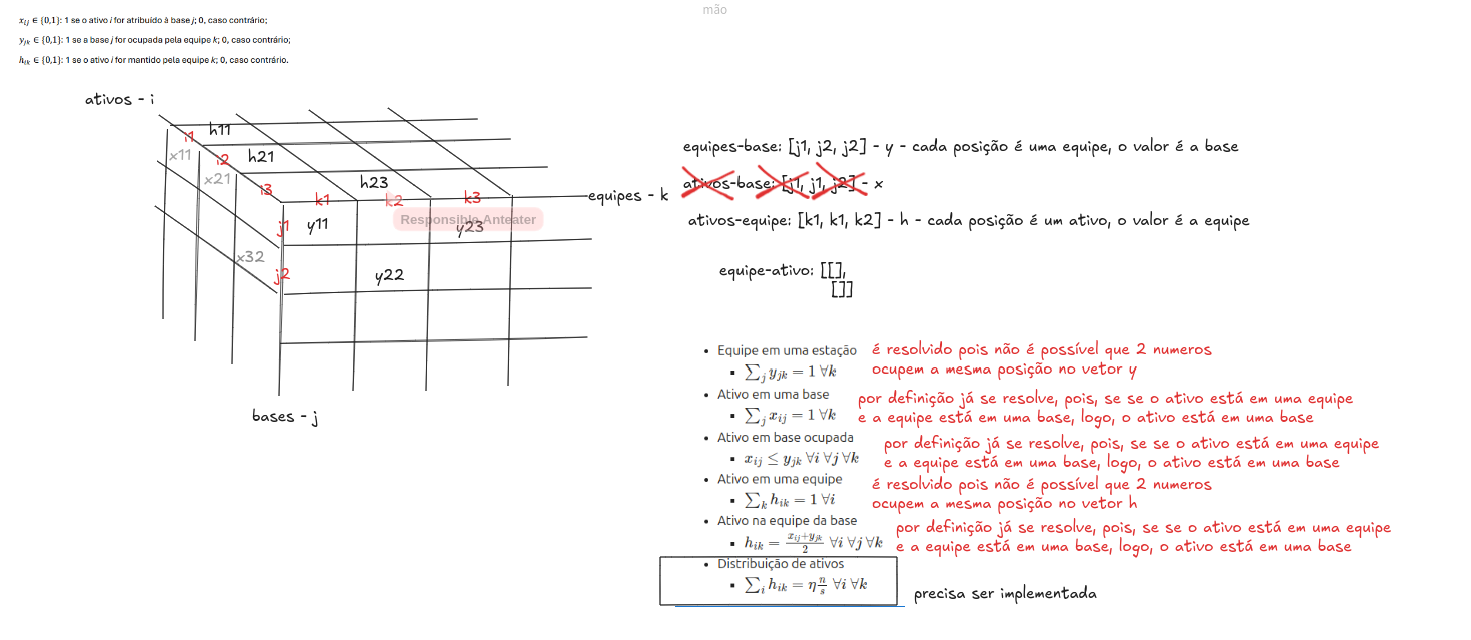

In [74]:
import pandas as pd
import seaborn as sns

In [3]:
data = pd.read_csv("probdata.csv", delimiter=";", header=None, decimal=',', names=[
    "Latitude_Base", "Longitude_Base", "Latitude_Ativo", "Longitude_Ativo", "Distância"
])
data.head()

,Latitude_Base,Longitude_Base,Latitude_Ativo,Longitude_Ativo,Distância
0,-20.423569,-43.856621,-19.985392,-43.813941,48.713894
1,-20.423569,-43.856621,-20.190501,-43.865241,25.818271
2,-20.423569,-43.856621,-20.347961,-43.802507,10.098339
3,-20.423569,-43.856621,-20.365050,-43.817596,7.652893
4,-20.423569,-43.856621,-20.351514,-43.816254,9.021712


In [94]:
ativos = data[['Latitude_Ativo', 'Longitude_Ativo']].drop_duplicates().reset_index()
ativos_map = {(r['Latitude_Ativo'], r['Longitude_Ativo']): i for i, r in ativos.iterrows()}

bases = data[['Latitude_Base', 'Longitude_Base']].drop_duplicates().reset_index()
bases_map = {(r['Latitude_Base'], r['Longitude_Base']): i for i, r in bases.iterrows()}
bases_map

data['ativo'] = data[['Latitude_Ativo', 'Longitude_Ativo']].apply(lambda r: ativos_map.get((r['Latitude_Ativo'], r['Longitude_Ativo'])), axis=1)
data['base'] = data[['Latitude_Base', 'Longitude_Base']].apply(lambda r: bases_map.get((r['Latitude_Base'], r['Longitude_Base'])), axis=1)
distance_matrix = data.set_index(['ativo', 'base'])[['Distância']].unstack(1).fillna(0)
distance_matrix.columns = distance_matrix.columns.droplevel(0)
distance_matrix

base,0,1,2,3,4,5,6,7,8,9,10,11,12,13
ativo,,,,,,,,,,,,,,
0,48.713894,48.562252,26.476049,19.841358,22.048155,18.670585,17.013641,15.745308,18.030074,31.870133,9.964037,13.787882,36.055486,17.582359
1,25.818271,25.426151,3.171888,4.202938,2.128542,10.189292,17.887548,20.563946,19.046618,26.211993,25.556960,37.090085,28.148261,13.956834
2,10.098339,11.205728,15.828007,22.821374,20.669217,28.521867,36.291323,39.102513,37.339409,41.385715,43.983464,53.780642,41.808427,32.315010
3,7.652893,8.755520,17.000837,24.152393,21.929026,29.593357,37.339171,40.229248,38.326665,41.567091,45.472287,55.718690,41.724697,33.364648
4,9.021712,9.943805,15.630932,22.747203,20.541050,28.268088,36.025578,38.891196,37.033901,40.608594,44.036029,54.215573,40.898061,32.048659
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,49.964927,49.413726,27.311838,20.082021,22.386676,16.173290,11.080445,8.642406,11.560834,24.746206,1.537258,16.382557,29.152685,13.465794
121,50.875089,50.377714,28.201413,20.992032,23.307327,17.390872,12.578052,10.178953,13.087867,26.272040,2.124386,14.863784,30.683652,14.830213
122,50.601751,50.116273,27.926951,20.724397,23.041001,17.208765,12.548208,10.219609,13.097492,26.364882,2.439451,14.885220,30.765106,14.709849


In [125]:
from dataclasses import dataclass, field

@dataclass
class problem_definition:
    # Definir parâmetros
    distance_matrix: pd.DataFrame
    ETA: float = 0.2                                                                   # Percentual para balanceamento de ativos (𝜂/m)
    n_equipes: int = 3                                                                 # Quantidade de equipes
    n_ativos: int = len(data[['Latitude_Ativo', 'Longitude_Ativo']].drop_duplicates())      # Número de ativos
    n_bases: int = len(data[['Latitude_Base', 'Longitude_Base']].drop_duplicates())        # Número de bases
    

prob_def = problem_definition(distance_matrix=distance_matrix)
# prob_def

In [88]:
@dataclass
class solution:
    ativo_equipe: list # h
    equipe_base: list # y
    fitness: float = 0
    penalidade: float = 0
    finess_penalizado: float = 0

    @property
    def ativo_base(self):
        x = []
        for equipe in self.ativo_equipe:
            base = self.equipe_base[equipe]
            x.append(base)
        return x            

In [98]:
# ativos = ['
ativos = [0,1,2,3]
equipes = [0,1,2]
base = [0,1]

h = [0,0,1,2] 
y = [1,0,1]

s = solution(ativo_equipe=h,equipe_base=y)
s

solution(ativo_equipe=[0, 0, 1, 2], equipe_base=[1, 0, 1], fitness=0, penalidade=0, finess_penalizado=0)

In [51]:
s.ativo_base

[1, 1, 0, 1]

In [53]:
'''
Implementa uma solução inicial para o problema
'''
def sol_inicial(probdata: problem_definition,apply_constructive_heuristic=False):
    
    '''  
    Modelou-se uma solução x como um vetor binário
    
    x = [x1 x2 ... xn]
    '''
    
    if apply_constructive_heuristic == False:
        # Constrói solução inicial aleatoriamente
        y = np.random.randint(0, probdata.n_bases, size=probdata.n_equipes)   
        h = np.random.randint(0, probdata.n_equipes, size=probdata.n_ativos)   
        sol = solution(equipe_base=y, ativo_equipe=h)
    else: # TODO
        pass    
    return sol

# Função objetivo 

In [126]:

'''
Implementa a função objetivo do problema
'''
def minimiza_distancias(x: solution, probdata: problem_definition):
    
    '''      
    x = [x1 x2 ... xn]
    '''
    
    ativo_base = x.ativo_base
    total_distance = 0
    for ativo, base in enumerate(ativo_base):
        d = probdata.distance_matrix.loc[ativo, base]
        total_distance += d

    x.fitness = total_distance
    
    print(total_distance)
    ativos_por_equipe = [len(np.where(np.array(x.ativo_equipe)== k)[0]) for k in range(prob_def.n_equipes)]
    penalidade = 0
    min_ativos = prob_def.ETA * prob_def.n_ativos / prob_def.n_equipes 
    print(f"Minimo de ativos:{min_ativos}")
    u = 100
    for equipe, qtd_ativos in enumerate(ativos_por_equipe):
        
        g = min_ativos - qtd_ativos
        print(f"Qtd. Ativos: {qtd_ativos} \t G: {g}")
        penalidade += u*max(0, g)**2

    x.penalidade = penalidade
    x.finess_penalizado  = total_distance + penalidade
    print(ativos_por_equipe)
    
    return x

In [127]:
minimiza_distancias(s, prob_def)

92.84226244000001
Minimo de ativos:8.333333333333334
Qtd. Ativos: 2 	 G: 6.333333333333334
Qtd. Ativos: 1 	 G: 7.333333333333334
Qtd. Ativos: 1 	 G: 7.333333333333334
[2, 1, 1]


solution(ativo_equipe=[0, 0, 1, 2], equipe_base=[1, 0, 1], fitness=np.float64(92.84226244000001), penalidade=14766.666666666668, finess_penalizado=np.float64(14859.508929106669))

In [101]:
import numpy as np

In [102]:
a = [0,0,1,1,1,1,1,2]

In [110]:
[len(np.where(np.array(a)== k)[0])  for k in range(4)]

[2, 5, 1, 0]

In [128]:
prob_def.ETA= 0

In [129]:
minimiza_distancias(s, prob_def)

92.84226244000001
Minimo de ativos:0.0
Qtd. Ativos: 2 	 G: -2.0
Qtd. Ativos: 1 	 G: -1.0
Qtd. Ativos: 1 	 G: -1.0
[2, 1, 1]


solution(ativo_equipe=[0, 0, 1, 2], equipe_base=[1, 0, 1], fitness=np.float64(92.84226244000001), penalidade=0, finess_penalizado=np.float64(92.84226244000001))

# Heurística

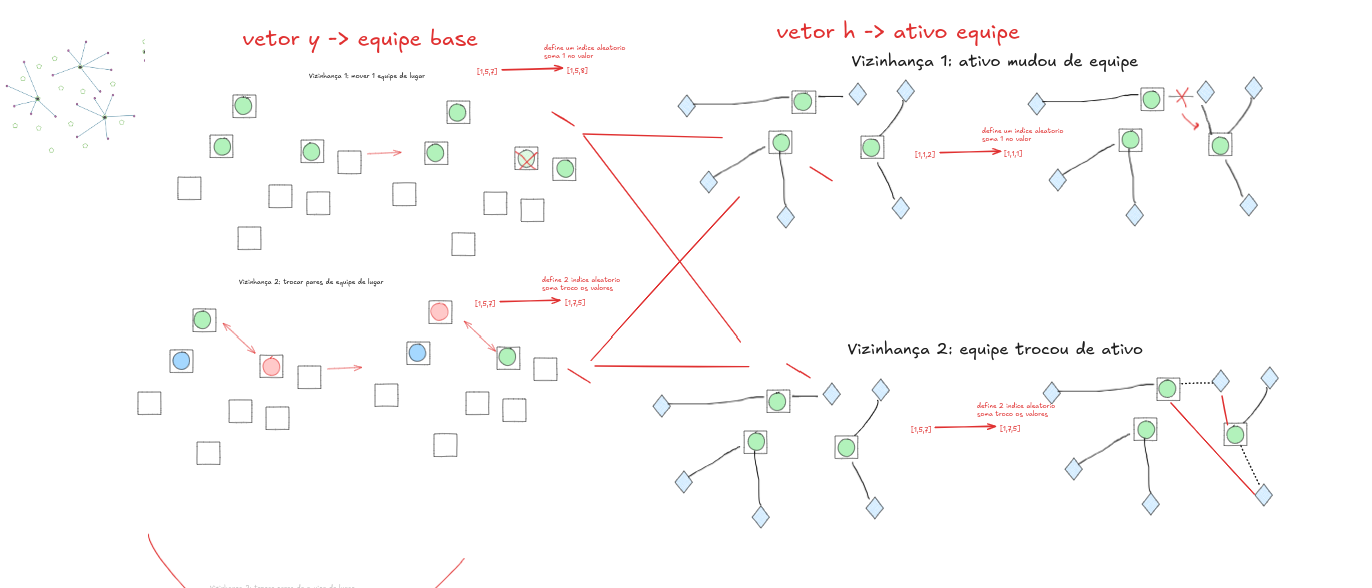

In [ ]:
'''
Implementa a função shake
'''
def shake(x,k,probdata):
    
    y = copy.deepcopy(x)
    r = np.random.permutation(probdata.n)       
    
    if k == 1:             # apply not operator in one random position
        y.solution[r[0]] = not(y.solution[r[0]])
        
    elif k == 2:           # apply not operator in two random positions        
        y.solution[r[0]] = not(y.solution[r[0]])
        y.solution[r[1]] = not(y.solution[r[1]])
        
    elif k == 3:           # apply not operator in three random positions
        y.solution[r[0]] = not(y.solution[r[0]])
        y.solution[r[1]] = not(y.solution[r[1]])
        y.solution[r[2]] = not(y.solution[r[2]])        
    
    return y